In [3]:
# Tutorial to Analyze healthData from here: 
# https://www.healthdata.gov/dataset/us-census-annual-estimates-resident-population-selected-age-groups-sex-united-states

import pandas as pd
import numpy as np
import scipy 
import sklearn 
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
print(pd.__version__)
print(np.__version__)
print(matplotlib.__version__)

0.23.0
1.12.1
2.2.2


In [15]:
# Lets see some corr or plots
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import seaborn as sns
import plotly.plotly as py #For World Map
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

In [16]:
# import Healthcareai package
import healthcareai
import healthcareai.trained_models.trained_supervised_model as tsm_plots
import healthcareai.common.database_connections as hcai_db

In [20]:
# Reada the Data and select importtant sample
#hdata = pd.read_csv('./Resident_Population_for_selected_age_group_United_States.csv')
#hdata.head(5)
#hdata.describe()
#hdata.shape
#hdata.dtypes
df = healthcareai.load_csv('./Resident_Population_for_selected_age_group_United_States.csv')
df.dtypes


YEAR                  int64
LocationAbbr         object
LocationDesc         object
TopicType            object
TopicDesc            object
DataSource           object
Data_Value_Type      object
Data_Value            int64
Gender               object
Age                  object
GeoLocation          object
Source_File_USCB     object
Data_Pulled          object
LocationID            int64
TopicTypeId          object
TopicId              object
MeasureId            object
StratificationID1    object
StratificationID2    object
SubMeasureID         object
DisplayOrder          int64
dtype: object

In [22]:
# First we have to clean some of the Data

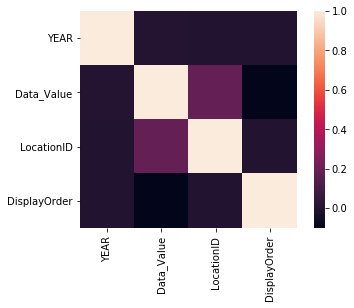

In [18]:
# Search for any correlation in data?
corr = df.corr()
sns.heatmap(corr, square = True)

so wwe find very little correlation amongst the variables e.g Data_Value is slightly correlated with LocationID and LocationID is also barely correlated with YEAR. Now lets look at some distribution of residents across the US Map

In [ ]:
import plotly.plotly as py

df[col] = df[col].astype(str)

scl = [[0.0, 'rgb(242,240,247)'],[0.2, 'rgb(218,218,235)'],[0.4, 'rgb(188,189,220)'],\
            [0.6, 'rgb(158,154,200)'],[0.8, 'rgb(117,107,177)'],[1.0, 'rgb(84,39,143)']]

df['text'] = df['state'] + '<br>' +\
    'Beef '+df['beef']+' Dairy '+df['dairy']+'<br>'+\
    'Fruits '+df['total fruits']+' Veggies ' + df['total veggies']+'<br>'+\
    'Wheat '+df['wheat']+' Corn '+df['corn']

data = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = df['code'],
        z = df['total exports'].astype(float),
        locationmode = 'USA-states',
        text = df['text'],
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            )
        ),
        colorbar = dict(
            title = "Millions USD"
        )
    ) ]

layout = dict(
        title = 'Resident Population by State<br>(Hover for breakdown)',
        geo = dict(
            scope='usa',
            projection=dict( type='albers usa' ),
            showlakes = True,
            lakecolor = 'rgb(255, 255, 255)',
        ),
    )

fig = dict(data=data, layout=layout)
#url = py.plot(fig, filename='d3-cloropleth-map') ## for webbrowser plotting
iplot(fig)

In [29]:
def main():
    # Load the included diabetes sample data
    #dataframe = healthcareai.load_diabetes()
    dataframe = df
    # ...or load your own data from a .csv file: Uncomment to pull data from your CSV
    # dataframe = healthcareai.load_csv('path/to/your.csv')

    # ...or load data from a MSSQL server: Uncomment to pull data from MSSQL server
    # server = 'localhost'
    # database = 'SAM'
    # query = """SELECT *
    #             FROM [SAM].[dbo].[DiabetesClincialSampleData]
    #             -- In this step, just grab rows that have a target
    #             WHERE ThirtyDayReadmitFLG is not null"""
    #
    # engine = hcai_db.build_build_mssql_engine_using_trusted_connectionsmssql_engine(server=server, database=database)
    # dataframe = pd.read_sql(query, engine)

    # Peek at the first 5 rows of data
    print(dataframe.head(5))

    # Drop columns that won't help machine learning
   # dataframe.drop(['PatientID'], axis=1, inplace=True)
    #dataframe.drop(['LocationID'], axis=1, inplace=True)

    # Step 1: Setup a healthcareai classification trainer. This prepares your data for model building
    classification_trainer = healthcareai.SupervisedModelTrainer(
        dataframe=dataframe,
        predicted_column='Data_Value',#'ThirtyDayReadmitFLG',
        model_type='classification',
        grain_column= 'YEAR', #'PatientEncounterID',
        impute=True,
        verbose=False)

    # Look at the first few rows of your dataframe after loading the data
    print('\n\n-------------------[ Cleaned Dataframe ]--------------------------')
    print(classification_trainer.clean_dataframe.head())

    # Step 2: train some models

    # Train a KNN model
    trained_knn = classification_trainer.knn()

    # View the ROC and PR plots
    trained_knn.roc_plot()
    trained_knn.pr_plot()

    # Uncomment if you want to see all the ROC and/or PR thresholds
    # trained_knn.roc()
    # trained_knn.pr()

    # Train a logistic regression model
    trained_lr = classification_trainer.logistic_regression()

    # View the ROC and PR plots
    trained_lr.roc_plot()
    trained_lr.pr_plot()

    # Uncomment if you want to see all the ROC and/or PR thresholds
    # trained_lr.roc()
    # trained_lr.pr()

    # Train a random forest model and view the feature importance plot
    trained_random_forest = classification_trainer.random_forest(save_plot=False)
    # View the ROC and PR plots
    trained_random_forest.roc_plot()
    trained_random_forest.pr_plot()

    # Uncomment if you want to see all the ROC and/or PR thresholds
    # trained_random_forest.roc()
    # trained_random_forest.pr()

    # Create a list of all the models you just trained that you want to compare
    models_to_compare = [trained_knn, trained_lr, trained_random_forest]

    # Create a ROC plot that compares them.
    tsm_plots.tsm_classification_comparison_plots(
        trained_supervised_models=models_to_compare,
        plot_type='ROC',
        save=False)

    # Create a PR plot that compares them.
    tsm_plots.tsm_classification_comparison_plots(
        trained_supervised_models=models_to_compare,
        plot_type='PR',
        save=False)

    # Once you are happy with the performance of any model, you can save it for use later in predicting new data.
    # File names are timestamped and look like '2017-05-31T12-36-21_classification_RandomForestClassifier.pkl')
    # Note the file you saved and that will be used in example_classification_2.py
    trained_random_forest.save()


In [30]:
if __name__ == "__main__":
    main()

   YEAR LocationAbbr LocationDesc TopicType            TopicDesc  \
0  2017           AL      Alabama    Census  Census - Population   
1  2017           AL      Alabama    Census  Census - Population   
2  2017           AL      Alabama    Census  Census - Population   
3  2017           AL      Alabama    Census  Census - Population   
4  2017           AL      Alabama    Census  Census - Population   

                    DataSource Data_Value_Type  Data_Value Gender    Age  \
0  United States Census Bureau           Count     4874747  Total  Total   
1  United States Census Bureau           Count     3779274  Total    18+   
2  United States Census Bureau           Count     1095473  Total    <18   
3  United States Census Bureau           Count     2359836   Male  Total   
4  United States Census Bureau           Count     1801775   Male    18+   

                               GeoLocation  \
0  (32.84057112200048, -86.63186076199969)   
1  (32.84057112200048, -86.63186076199969)

TypeError: Cannot compare types 'ndarray(dtype=int64)' and 'str'